# Predicting Poverty (SDG 1) Using Satellite Embeddings

This notebook demonstrates how to use Random Forest regression to predict the SDG 1 Index (No Poverty) using 64-dimensional satellite imagery embeddings from Google Earth Engine.

## Objectives
1. Load and merge SDG indices with satellite embeddings
2. Build a Random Forest model with cross-validation
3. Analyze feature importance
4. Evaluate model performance
5. Visualize predictions spatially

## 1. Setup and Data Loading

In [1]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy scikit-learn matplotlib seaborn geopandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Define repository URL
REPO_URL = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master"

# Load datasets
print("Loading datasets...")
url_names = f"{REPO_URL}/regionNames/regionNames.csv"
url_sdg = f"{REPO_URL}/sdg/sdg.csv"
url_embeddings = f"{REPO_URL}/satelliteEmbeddings/satelliteEmbeddings2017.csv"

df_names = pd.read_csv(url_names)
df_sdg = pd.read_csv(url_sdg)
df_embeddings = pd.read_csv(url_embeddings)

print(f"✓ Loaded {len(df_names)} municipalities")
print(f"✓ Loaded {len(df_sdg.columns)-1} SDG variables")
print(f"✓ Loaded {len(df_embeddings.columns)-1} satellite embedding dimensions")

Loading datasets...
✓ Loaded 339 municipalities
✓ Loaded 16 SDG variables
✓ Loaded 64 satellite embedding dimensions


## 2. Data Preparation

In [4]:
# Merge datasets
df = pd.merge(df_names, df_sdg, on='asdf_id', how='inner')
df = pd.merge(df, df_embeddings, on='asdf_id', how='inner')

print(f"Merged dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df[['mun', 'dep', 'index_sdg1', 'A00', 'A01', 'A02']].head()

Merged dataset shape: (339, 88)

First few rows:


,mun,dep,index_sdg1,A00,A01,A02
0,Esmeralda,Oruro,34.759998,-0.060433,-0.052295,-0.009320
1,Quillacas,Oruro,27.950001,-0.104140,0.013027,-0.063797
2,Pampa Aullagas,Oruro,18.910000,-0.107063,0.021826,-0.036949
3,Llallagua,Potosí,60.480000,-0.130482,-0.044621,-0.114217
4,Caripuyo,Potosí,18.889999,-0.123298,-0.058626,-0.108308


In [5]:
# Check for missing values in target variable
print(f"Missing values in SDG 1 Index: {df['index_sdg1'].isna().sum()}")

# Remove any rows with missing target or features
embedding_cols = [col for col in df.columns if col.startswith('A')]
df_clean = df[['asdf_id', 'mun', 'dep', 'index_sdg1'] + embedding_cols].dropna()

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Number of embedding features: {len(embedding_cols)}")

Missing values in SDG 1 Index: 0
Clean dataset shape: (339, 68)
Number of embedding features: 64


In [6]:
# Prepare features (X) and target (y)
X = df_clean[embedding_cols].values
y = df_clean['index_sdg1'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget variable statistics:")
print(f"Mean: {y.mean():.2f}")
print(f"Std: {y.std():.2f}")
print(f"Min: {y.min():.2f}")
print(f"Max: {y.max():.2f}")

Features shape: (339, 64)
Target shape: (339,)

Target variable statistics:
Mean: 37.46
Std: 20.91
Min: 0.06
Max: 90.46


## 3. Exploratory Analysis

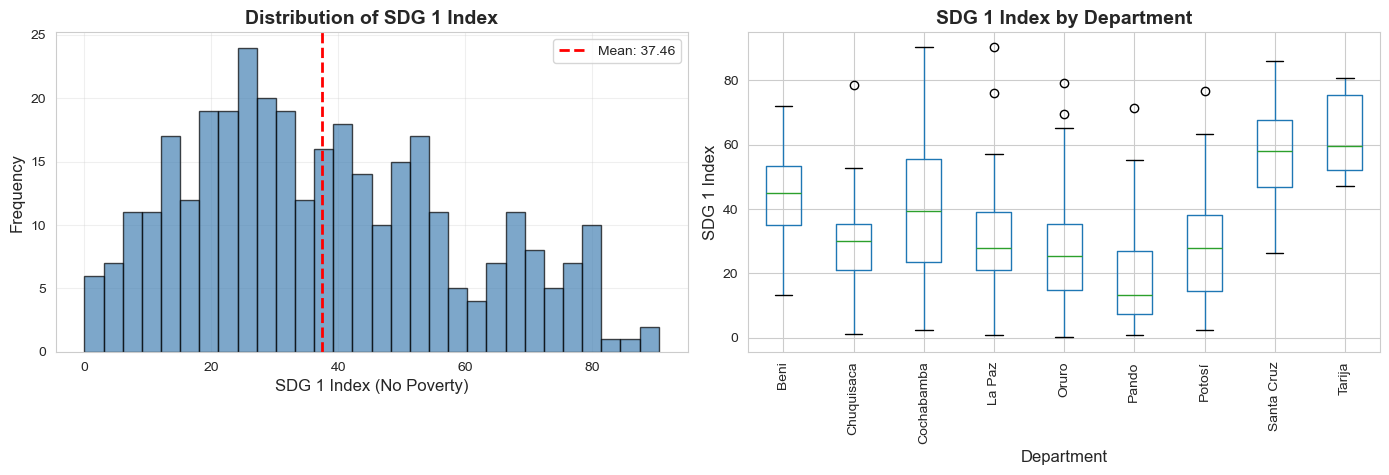

In [7]:
# Distribution of SDG 1 Index
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.2f}')
axes[0].set_xlabel('SDG 1 Index (No Poverty)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of SDG 1 Index', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by department
df_clean.boxplot(column='index_sdg1', by='dep', ax=axes[1], rot=90)
axes[1].set_xlabel('Department', fontsize=12)
axes[1].set_ylabel('SDG 1 Index', fontsize=12)
axes[1].set_title('SDG 1 Index by Department', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

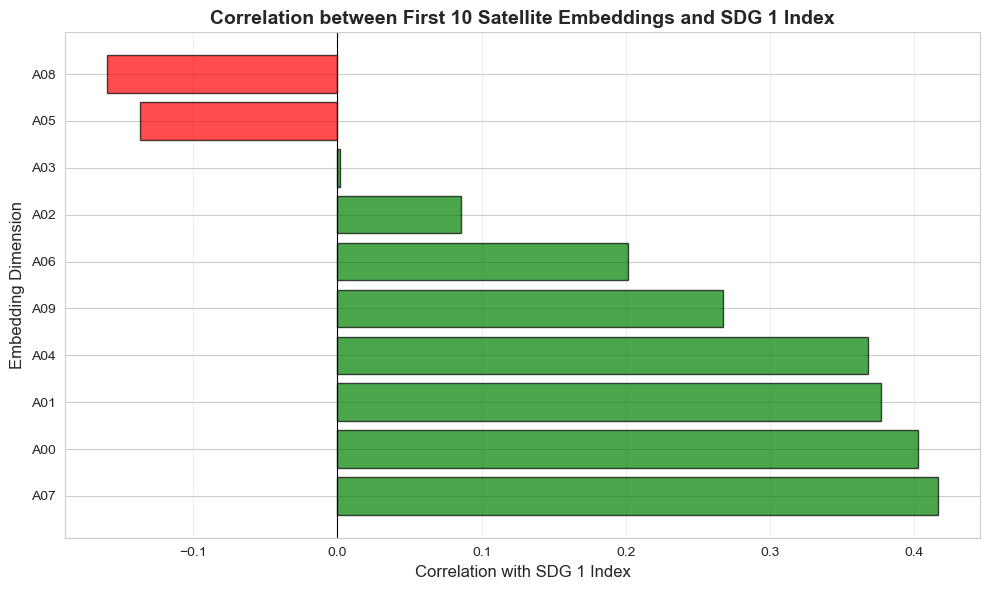

In [8]:
# Correlation between first 10 embeddings and SDG 1
corr_data = df_clean[['index_sdg1'] + embedding_cols[:10]].corr()['index_sdg1'][1:].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in corr_data.values]
plt.barh(corr_data.index, corr_data.values, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Correlation with SDG 1 Index', fontsize=12)
plt.ylabel('Embedding Dimension', fontsize=12)
plt.title('Correlation between First 10 Satellite Embeddings and SDG 1 Index', fontsize=14, fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 4. Model Training with Cross-Validation

In [9]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 271
Test set size: 68


In [10]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Model Configuration:")
print(f"  - n_estimators: {rf_model.n_estimators}")
print(f"  - max_depth: {rf_model.max_depth}")
print(f"  - min_samples_split: {rf_model.min_samples_split}")
print(f"  - min_samples_leaf: {rf_model.min_samples_leaf}")
print(f"  - max_features: {rf_model.max_features}")

Model Configuration:
  - n_estimators: 500
  - max_depth: 10
  - min_samples_split: 5
  - min_samples_leaf: 2
  - max_features: sqrt


In [11]:
# Perform 5-fold cross-validation on training set
print("\nPerforming 5-fold cross-validation...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_r2 = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)
cv_scores_mse = -cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
cv_scores_mae = -cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)

print("\n📊 Cross-Validation Results (5-Fold):")
print(f"  R² Score:  {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std():.4f})")
print(f"  RMSE:      {np.sqrt(cv_scores_mse.mean()):.4f} (±{np.sqrt(cv_scores_mse.std()):.4f})")
print(f"  MAE:       {cv_scores_mae.mean():.4f} (±{cv_scores_mae.std():.4f})")


Performing 5-fold cross-validation...

📊 Cross-Validation Results (5-Fold):
  R² Score:  0.3614 (±0.0685)
  RMSE:      16.1774 (±6.4349)
  MAE:       12.8306 (±0.8133)


In [12]:
# Train final model on full training set
print("\nTraining final model on full training set...")
rf_model.fit(X_train, y_train)
print("✓ Model training complete!")


Training final model on full training set...
✓ Model training complete!


## 5. Model Evaluation

In [13]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n🎯 Model Performance:")
print("\nTraining Set:")
print(f"  R² Score:  {train_r2:.4f}")
print(f"  RMSE:      {train_rmse:.4f}")
print(f"  MAE:       {train_mae:.4f}")

print("\nTest Set:")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  RMSE:      {test_rmse:.4f}")
print(f"  MAE:       {test_mae:.4f}")

print(f"\nOverfitting Check:")
print(f"  R² Difference: {train_r2 - test_r2:.4f}")
if (train_r2 - test_r2) < 0.1:
    print("  ✓ Model shows good generalization")
else:
    print("  ⚠ Model may be overfitting")


🎯 Model Performance:

Training Set:
  R² Score:  0.8503
  RMSE:      7.9113
  MAE:       6.0681

Test Set:
  R² Score:  0.4025
  RMSE:      17.4770
  MAE:       13.3347

Overfitting Check:
  R² Difference: 0.4478
  ⚠ Model may be overfitting


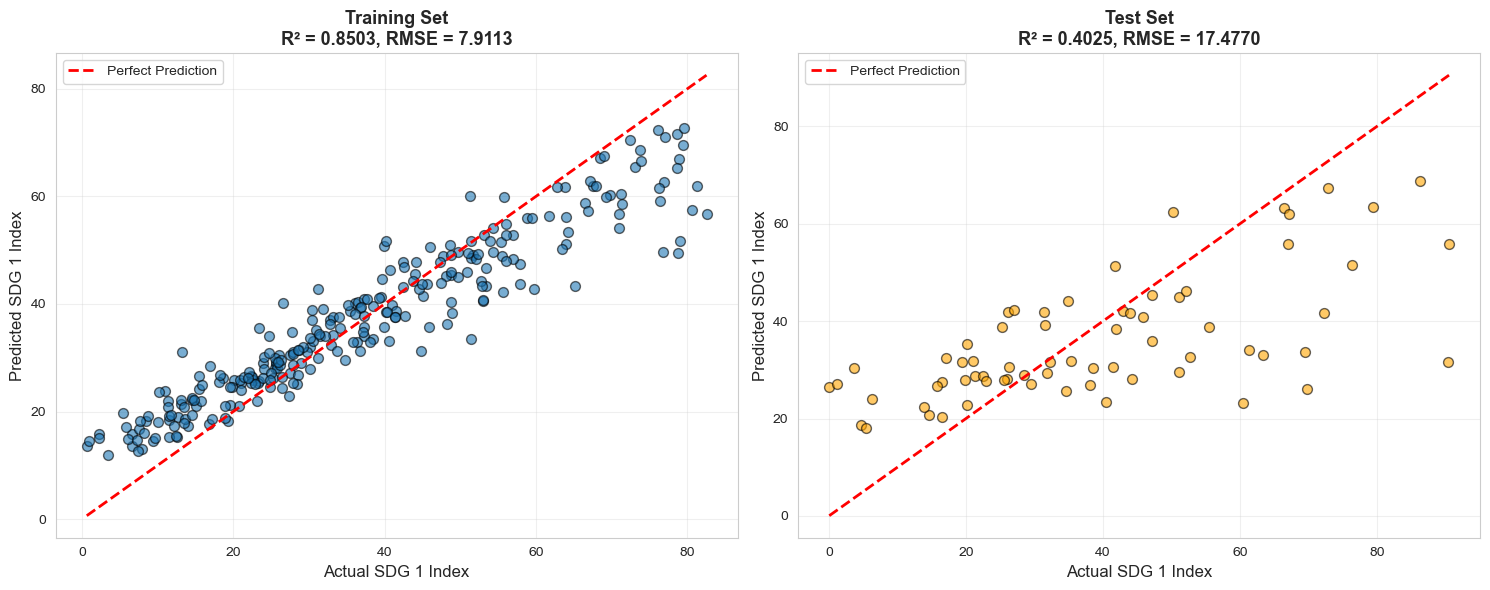

In [14]:
# Predicted vs Actual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolor='black', s=50)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual SDG 1 Index', fontsize=12)
axes[0].set_ylabel('Predicted SDG 1 Index', fontsize=12)
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}, RMSE = {train_rmse:.4f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolor='black', s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual SDG 1 Index', fontsize=12)
axes[1].set_ylabel('Predicted SDG 1 Index', fontsize=12)
axes[1].set_title(f'Test Set\nR² = {test_r2:.4f}, RMSE = {test_rmse:.4f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

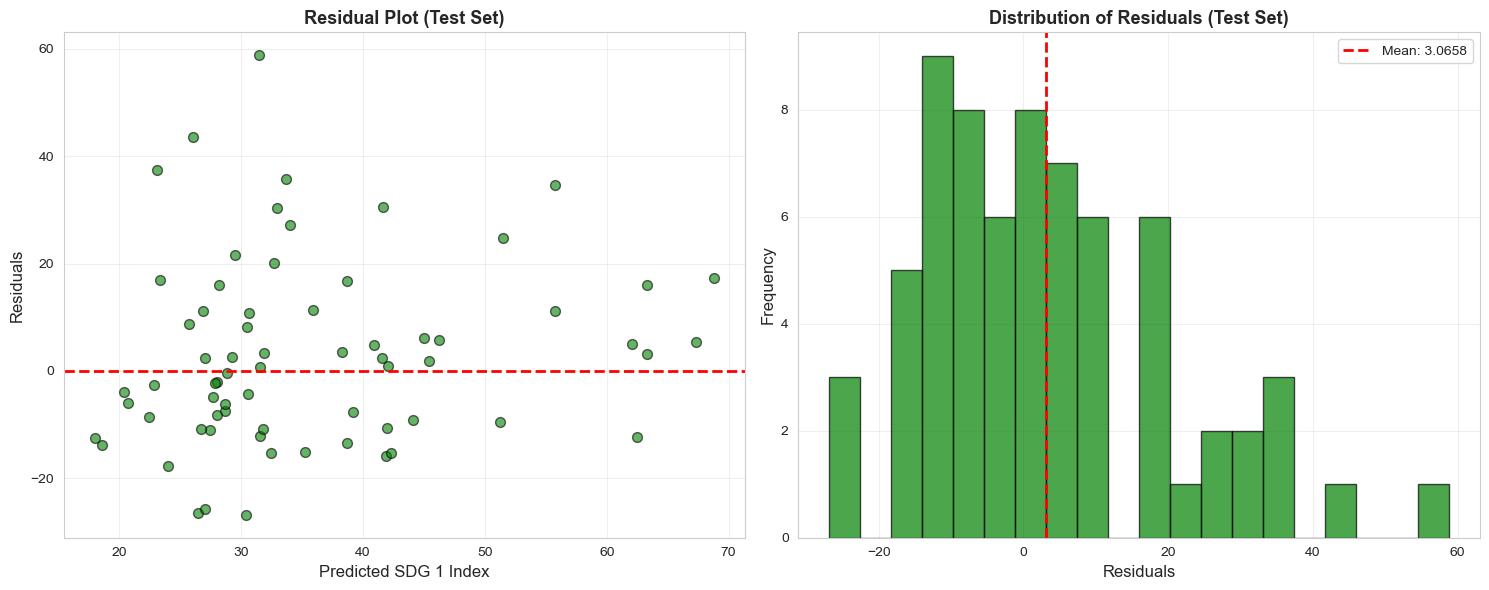

In [15]:
# Residual analysis
residuals_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs Predicted
axes[0].scatter(y_test_pred, residuals_test, alpha=0.6, edgecolor='black', s=50, color='green')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted SDG 1 Index', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Residual Plot (Test Set)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residuals distribution
axes[1].hist(residuals_test, bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(residuals_test.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {residuals_test.mean():.4f}')
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals (Test Set)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

In [16]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': embedding_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🌟 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))


🌟 Top 20 Most Important Features:
feature  importance
    A43    0.047690
    A59    0.038572
    A13    0.036800
    A07    0.035766
    A04    0.031138
    A32    0.029811
    A52    0.028292
    A01    0.027632
    A10    0.025274
    A25    0.024695
    A30    0.024305
    A21    0.020256
    A33    0.019772
    A00    0.019527
    A54    0.019363
    A58    0.019124
    A57    0.017411
    A26    0.017320
    A31    0.016077
    A37    0.015848


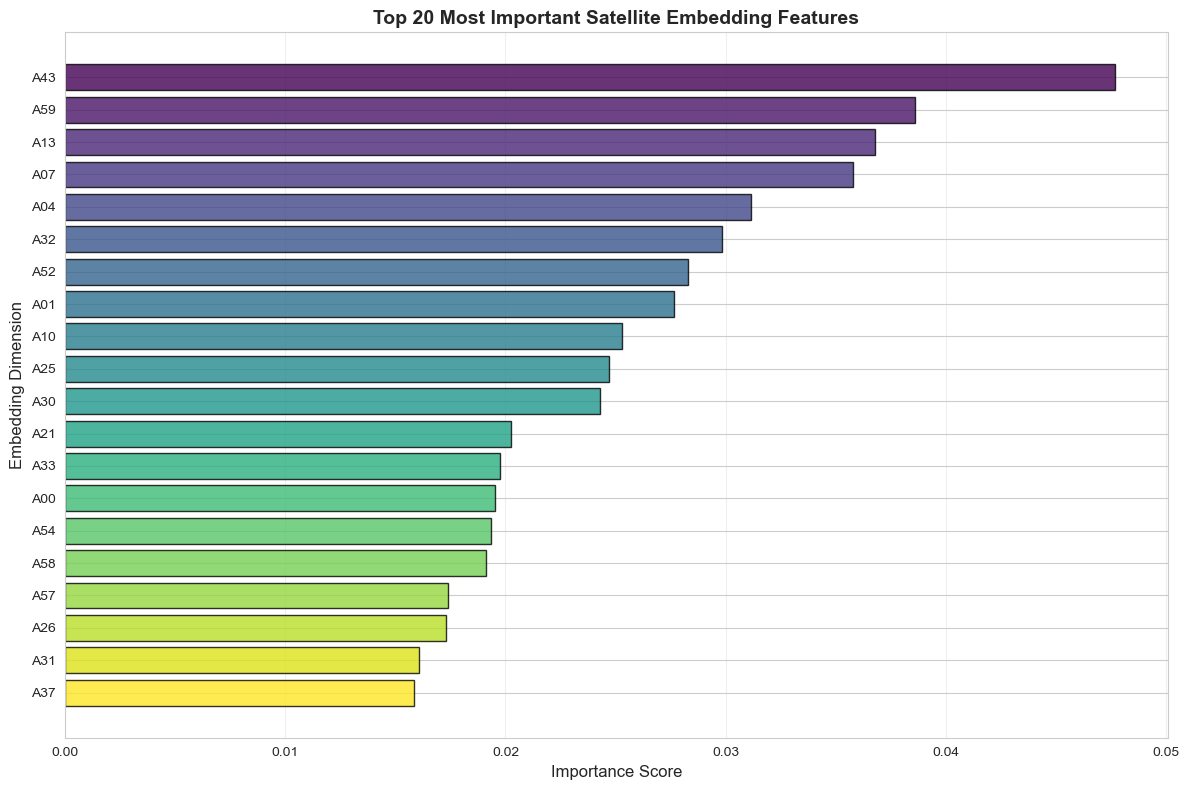

In [17]:
# Visualize top 20 features
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, top_n))
plt.barh(range(top_n), top_features['importance'].values, color=colors, edgecolor='black', alpha=0.8)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Embedding Dimension', fontsize=12)
plt.title(f'Top {top_n} Most Important Satellite Embedding Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


📊 Cumulative Importance Analysis:
  Features needed for 80% importance: 43 (67.2%)
  Features needed for 95% importance: 58 (90.6%)


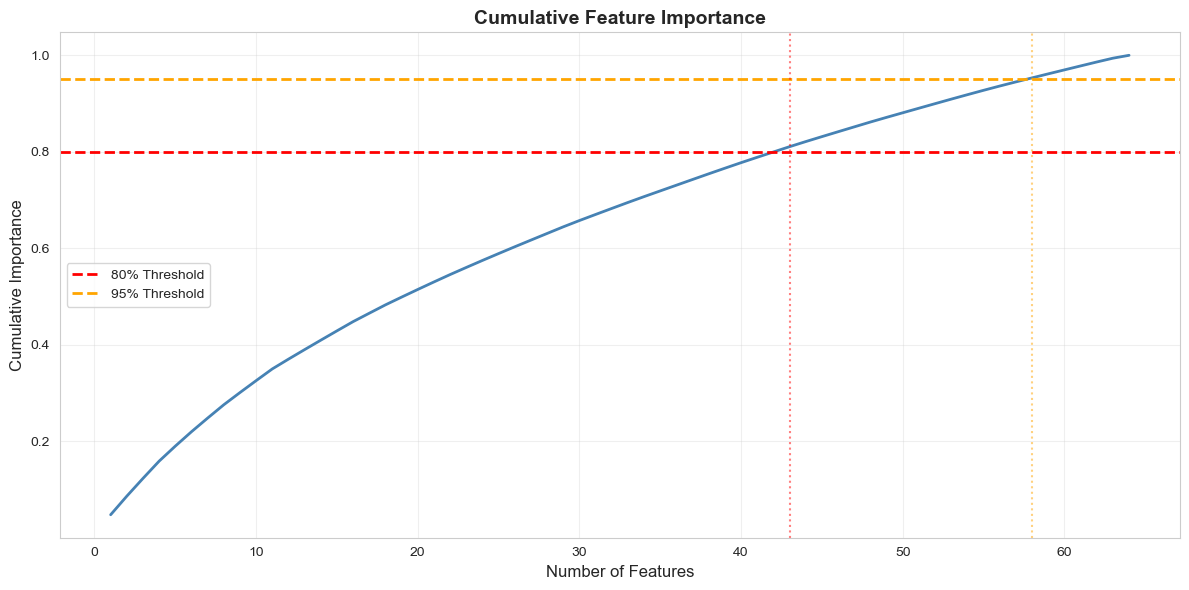

In [18]:
# Cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

# Find number of features needed for 80% and 95% importance
n_features_80 = (feature_importance['cumulative_importance'] <= 0.80).sum() + 1
n_features_95 = (feature_importance['cumulative_importance'] <= 0.95).sum() + 1

print(f"\n📊 Cumulative Importance Analysis:")
print(f"  Features needed for 80% importance: {n_features_80} ({n_features_80/len(embedding_cols)*100:.1f}%)")
print(f"  Features needed for 95% importance: {n_features_95} ({n_features_95/len(embedding_cols)*100:.1f}%)")

# Plot cumulative importance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(feature_importance) + 1), 
         feature_importance['cumulative_importance'].values, 
         linewidth=2, color='steelblue')
plt.axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='80% Threshold')
plt.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95% Threshold')
plt.axvline(x=n_features_80, color='red', linestyle=':', alpha=0.5)
plt.axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

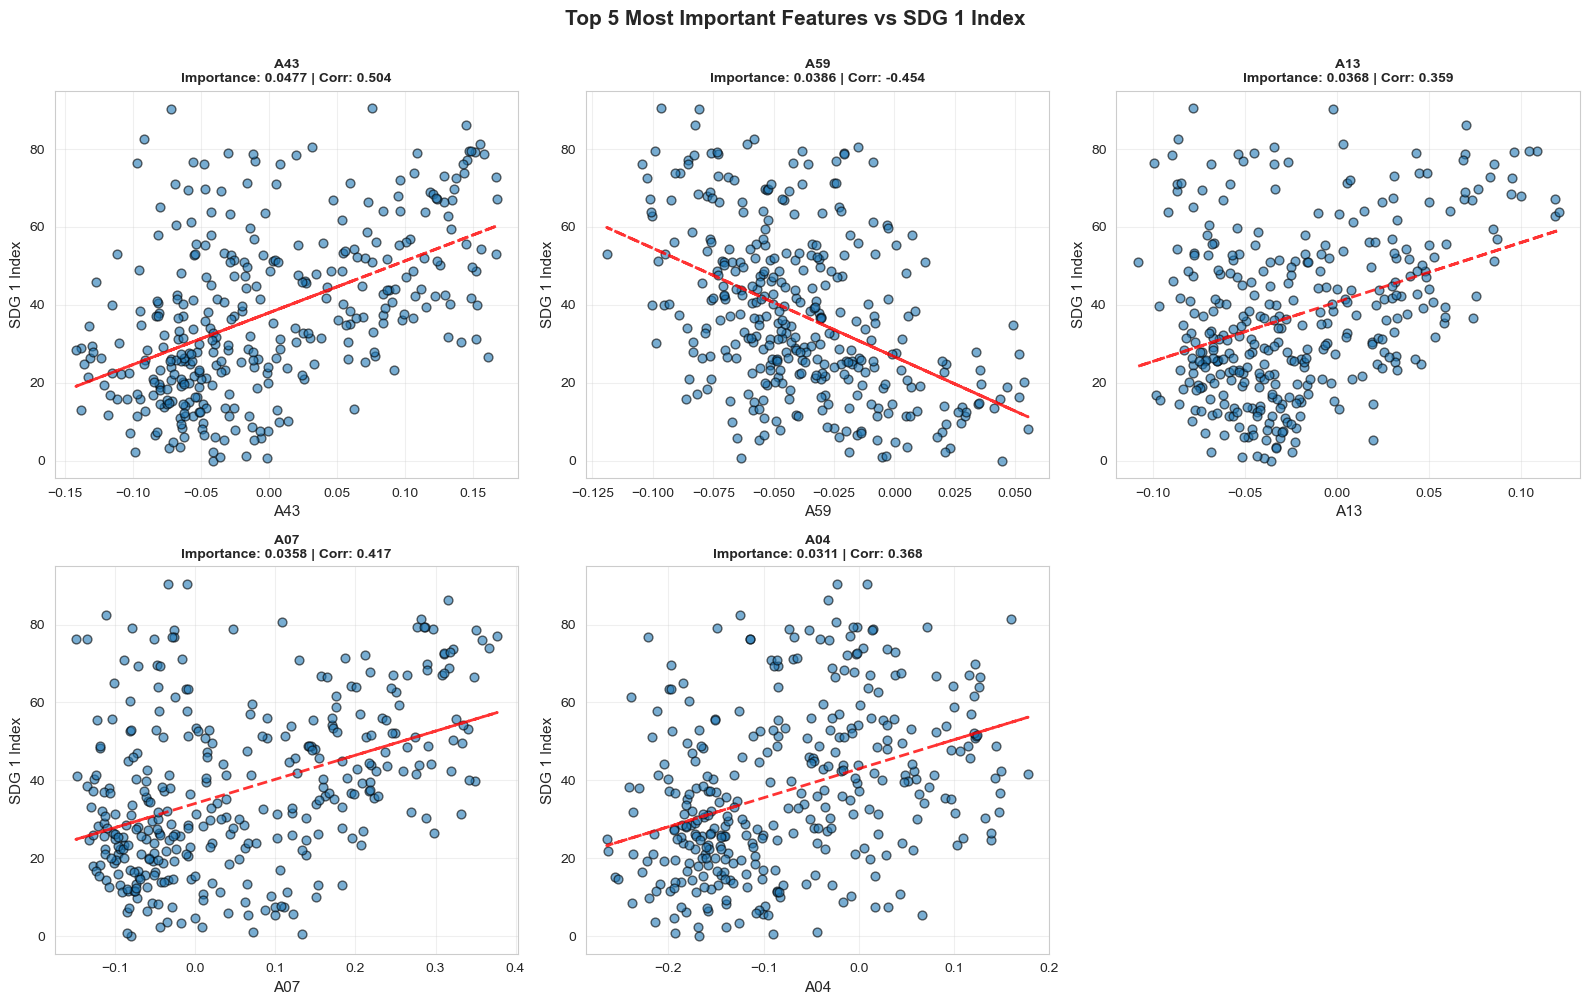

In [19]:
# Analyze relationship between top features and target
top_5_features = feature_importance.head(5)['feature'].values

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_5_features):
    ax = axes[idx]
    ax.scatter(df_clean[feature], df_clean['index_sdg1'], alpha=0.6, edgecolor='black', s=40)
    
    # Add trend line
    z = np.polyfit(df_clean[feature], df_clean['index_sdg1'], 1)
    p = np.poly1d(z)
    ax.plot(df_clean[feature], p(df_clean[feature]), "r--", linewidth=2, alpha=0.8)
    
    # Calculate correlation
    corr = df_clean[[feature, 'index_sdg1']].corr().iloc[0, 1]
    
    ax.set_xlabel(f'{feature}', fontsize=11)
    ax.set_ylabel('SDG 1 Index', fontsize=11)
    ax.set_title(f'{feature}\nImportance: {feature_importance[feature_importance["feature"]==feature]["importance"].values[0]:.4f} | Corr: {corr:.3f}', 
                 fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Top 5 Most Important Features vs SDG 1 Index', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Spatial Visualization of Predictions

In [20]:
# Predict for all municipalities
y_pred_all = rf_model.predict(X)

# Create results dataframe
results_df = df_clean[['asdf_id', 'mun', 'dep', 'index_sdg1']].copy()
results_df['predicted_sdg1'] = y_pred_all
results_df['residual'] = results_df['index_sdg1'] - results_df['predicted_sdg1']
results_df['abs_error'] = np.abs(results_df['residual'])

print("\n📍 Municipalities with Largest Prediction Errors:")
print("\nTop 10 Overpredictions (Model predicts higher than actual):")
print(results_df.nlargest(10, 'residual')[['mun', 'dep', 'index_sdg1', 'predicted_sdg1', 'residual']].to_string(index=False))

print("\nTop 10 Underpredictions (Model predicts lower than actual):")
print(results_df.nsmallest(10, 'residual')[['mun', 'dep', 'index_sdg1', 'predicted_sdg1', 'residual']].to_string(index=False))


📍 Municipalities with Largest Prediction Errors:

Top 10 Overpredictions (Model predicts higher than actual):
        mun        dep  index_sdg1  predicted_sdg1  residual
     La Paz     La Paz   90.309998       31.502184 58.807814
Huachacalla      Oruro   69.680000       26.084295 43.595705
  Llallagua     Potosí   60.480000       23.086219 37.393781
      Vinto Cochabamba   69.419998       33.683542 35.736456
Colcapirhua Cochabamba   90.459999       55.728779 34.731220
   Trinidad       Beni   72.180000       41.641072 30.538928
     Tupiza     Potosí   63.369999       32.973695 30.396304
      Sucre Chuquisaca   78.739998       49.468303 29.271695
      Oruro      Oruro   79.080002       51.765806 27.314196
     Atocha     Potosí   61.320000       34.046051 27.273949

Top 10 Underpredictions (Model predicts lower than actual):
         mun        dep  index_sdg1  predicted_sdg1   residual
  Tinguipaya     Potosí    3.600000       30.394357 -26.794357
    El Choro      Oruro    0.06

In [21]:
# Load spatial data for mapping
try:
    import geopandas as gpd
    
    geojson_url = f"{REPO_URL}/maps/bolivia339geoqueryOpt.geojson"
    print("Loading GeoJSON map...")
    gdf = gpd.read_file(geojson_url)
    gdf['asdf_id'] = gdf['asdf_id'].astype(int)
    
    # Merge with predictions
    gdf_results = gdf.merge(results_df, on='asdf_id', how='inner')
    
    print(f"✓ Loaded spatial data for {len(gdf_results)} municipalities")
    
except ImportError:
    print("⚠ GeoPandas not available. Skipping spatial visualization.")
    print("  Install with: !pip install geopandas")
    gdf_results = None

⚠ GeoPandas not available. Skipping spatial visualization.
  Install with: !pip install geopandas


In [22]:
# Create spatial comparison maps
if gdf_results is not None:
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Actual SDG 1
    gdf_results.plot(column='index_sdg1', cmap='RdYlGn', linewidth=0.2, 
                     edgecolor='white', legend=True, ax=axes[0],
                     legend_kwds={'label': 'SDG 1 Index', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[0].set_title('Actual SDG 1 Index\n(No Poverty)', fontsize=13, fontweight='bold')
    axes[0].set_axis_off()
    
    # Predicted SDG 1
    gdf_results.plot(column='predicted_sdg1', cmap='RdYlGn', linewidth=0.2, 
                     edgecolor='white', legend=True, ax=axes[1],
                     legend_kwds={'label': 'Predicted SDG 1', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[1].set_title('Predicted SDG 1 Index\n(Random Forest)', fontsize=13, fontweight='bold')
    axes[1].set_axis_off()
    
    # Residuals
    gdf_results.plot(column='residual', cmap='RdBu', linewidth=0.2, 
                     edgecolor='white', legend=True, ax=axes[2],
                     legend_kwds={'label': 'Residual (Actual - Predicted)', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[2].set_title('Prediction Residuals\n(Red = Underpredicted, Blue = Overpredicted)', 
                      fontsize=13, fontweight='bold')
    axes[2].set_axis_off()
    
    plt.suptitle('Spatial Distribution: Actual vs Predicted SDG 1 Index', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
else:
    print("Spatial visualization skipped (GeoPandas not available)")

Spatial visualization skipped (GeoPandas not available)


## 8. Summary and Insights

In [23]:
print("\n" + "="*80)
print("MODEL SUMMARY: Random Forest for SDG 1 Poverty Prediction")
print("="*80)

print("\n📊 PERFORMANCE METRICS:")
print(f"  Cross-Validation R² (5-fold): {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std():.4f})")
print(f"  Test Set R²:                  {test_r2:.4f}")
print(f"  Test Set RMSE:                {test_rmse:.4f}")
print(f"  Test Set MAE:                 {test_mae:.4f}")

print("\n🌟 FEATURE IMPORTANCE:")
print(f"  Total embedding dimensions:   {len(embedding_cols)}")
print(f"  Features for 80% importance:  {n_features_80} ({n_features_80/len(embedding_cols)*100:.1f}%)")
print(f"  Features for 95% importance:  {n_features_95} ({n_features_95/len(embedding_cols)*100:.1f}%)")
print(f"\n  Top 5 Features: {', '.join(top_5_features)}")

print("\n🎯 KEY INSIGHTS:")
if test_r2 > 0.7:
    print("  ✓ Strong predictive power: Satellite embeddings capture poverty patterns well")
elif test_r2 > 0.5:
    print("  ✓ Moderate predictive power: Satellite embeddings provide useful poverty signals")
else:
    print("  ⚠ Limited predictive power: Additional features may be needed")

if (train_r2 - test_r2) < 0.1:
    print("  ✓ Good generalization: Model performs consistently on unseen data")
else:
    print("  ⚠ Potential overfitting: Consider regularization or ensemble approaches")

print("\n💡 RECOMMENDATIONS:")
print("  1. Consider using only top features for a more parsimonious model")
print("  2. Investigate municipalities with large prediction errors for local patterns")
print("  3. Combine satellite embeddings with other socioeconomic indicators")
print("  4. Explore temporal dynamics with multi-year satellite data")
print("  5. Test other ensemble methods (XGBoost, LightGBM) for comparison")

print("\n" + "="*80)


MODEL SUMMARY: Random Forest for SDG 1 Poverty Prediction

📊 PERFORMANCE METRICS:
  Cross-Validation R² (5-fold): 0.3614 (±0.0685)
  Test Set R²:                  0.4025
  Test Set RMSE:                17.4770
  Test Set MAE:                 13.3347

🌟 FEATURE IMPORTANCE:
  Total embedding dimensions:   64
  Features for 80% importance:  43 (67.2%)
  Features for 95% importance:  58 (90.6%)

  Top 5 Features: A43, A59, A13, A07, A04

🎯 KEY INSIGHTS:
  ⚠ Limited predictive power: Additional features may be needed
  ⚠ Potential overfitting: Consider regularization or ensemble approaches

💡 RECOMMENDATIONS:
  1. Consider using only top features for a more parsimonious model
  2. Investigate municipalities with large prediction errors for local patterns
  3. Combine satellite embeddings with other socioeconomic indicators
  4. Explore temporal dynamics with multi-year satellite data
  5. Test other ensemble methods (XGBoost, LightGBM) for comparison



## 9. Export Results (Optional)

In [24]:
# Uncomment to save results
# results_df.to_csv('sdg1_predictions_rf.csv', index=False)
# feature_importance.to_csv('feature_importance_rf.csv', index=False)
# print("✓ Results exported successfully")

---

## Conclusion

This notebook demonstrated how to:
1. ✅ Load and merge SDG indices with satellite embeddings from DS4Bolivia
2. ✅ Build and validate a Random Forest regression model
3. ✅ Analyze feature importance to understand which embedding dimensions matter most
4. ✅ Evaluate model performance with multiple metrics
5. ✅ Visualize predictions spatially to identify geographic patterns

The model shows that satellite imagery features can effectively predict poverty indicators at the municipal level in Bolivia, providing a scalable approach for poverty mapping in data-scarce regions.

### Next Steps
- Try other SDG indices (SDG 2: Zero Hunger, SDG 3: Good Health, etc.)
- Experiment with different model architectures (XGBoost, Neural Networks)
- Incorporate temporal features using night-time lights and population data
- Perform spatial cross-validation to account for spatial autocorrelation

### Citation
If you use this analysis, please cite:

Mendez, C., Gonzales, E., Leoni, P., Andersen, L., Peralta, H. (2026). DS4Bolivia: A Data Science Repository to Study GeoSpatial Development in Bolivia [Data set]. GitHub. https://github.com/quarcs-lab/ds4bolivia